# Imports

In [2]:
# Upload data on google drive and call it in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import sys
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time

In [4]:
pip install auto-sklearn

     |████████████████████████████████| 6.3 MB 9.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 22.3 MB 65.2 MB/s 
     |████████████████████████████████| 722 kB 48.3 MB/s 
     |████████████████████████████████| 4.2 MB 29.8 MB/s 
     |████████████████████████████████| 4.0 MB 46.9 MB/s 
     |████████████████████████████████| 208 kB 47.3 MB/s 
     |████████████████████████████████| 973 kB 49.6 MB/s 
     |████████████████████████████████| 132 kB 53.9 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.2-py3-none-any.whl size=6586738 sha256=f57d7d88a2916f3b68bd41aa41641666d131e9b28fd1d12cddee08f868d3152f
  Stored in directory: /root/.cache/pip/wheels/b6/ba/aa/ce7b8deb41019b9c1c6cd0b511d553350b7075ba1d3f0f545c
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7044 sha256=10093e48638fb808c0e683ba8a213acc6a12c5135214acf5f600fab35c440c

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import accuracy
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Loading & Pre-Processing

In [2]:
# copy data file into content in colab to be used 
!cp /content/drive/MyDrive/Sentiment_Analysis/data.zip /content 

In [3]:
# convert zip files to normal file so we can call its content 
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [81]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)




In [82]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [83]:
dataset

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


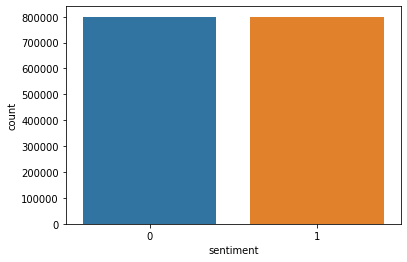

In [9]:
sns.countplot(dataset['sentiment'])

In [28]:
dataset.isnull().sum()

sentiment    0
text         0
dtype: int64

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [31]:
# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [32]:
def preprocess(textdata):
    processedText = []
    stopwords_english = stopwords.words('english')
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if (word not in stopwords_english):
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [33]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [34]:
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 162 seconds


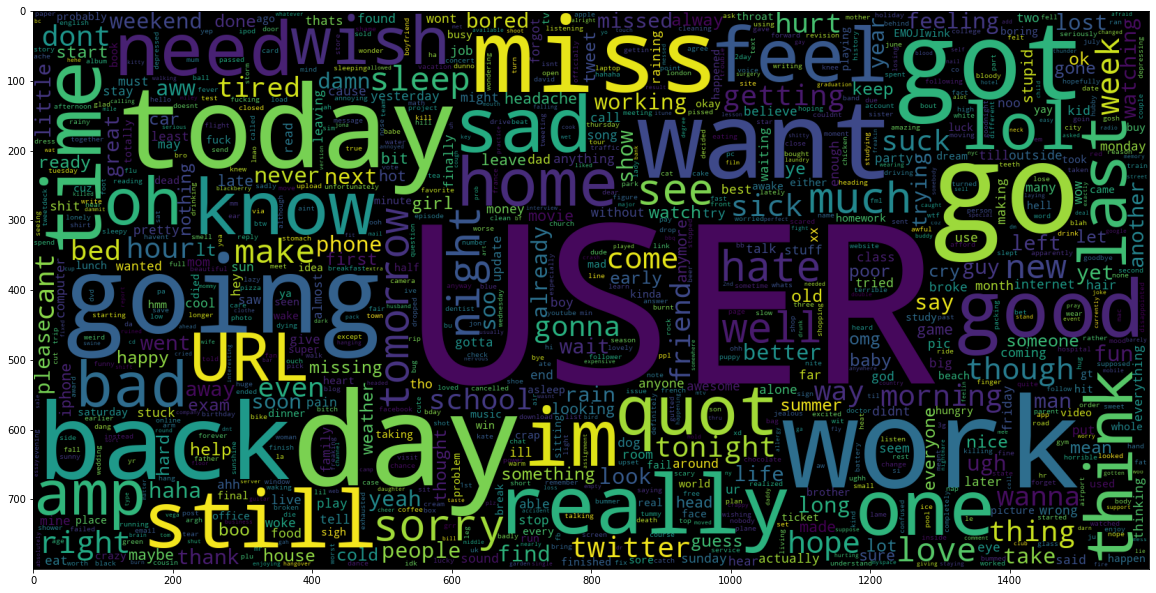

In [35]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [37]:
# feature extraction
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000)  # Convert a collection of raw documents to a matrix of TF-IDF features.
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  5000


In [38]:
# Transform dictionary features into 2D feature matrix.
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Modeling & Evaluating

In [39]:
import autosklearn
print(autosklearn.__version__)

0.14.2


In [69]:
model = AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=30, n_jobs=8, metric=accuracy,memory_limit=5000)

In [ ]:
# perform the search
model.fit(X_train, y_train)

In [72]:
# summarize
print(model.sprint_statistics())

auto-sklearn results:
  Dataset name: 7b35cd5c-5b36-11ec-8165-0242ac1c0002
  Metric: accuracy
  Number of target algorithm runs: 273
  Number of successful target algorithm runs: 0
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 261
  Number of target algorithms that exceeded the memory limit: 12



In [73]:
# evaluate best model
y_hat = model.predict(X_test)

In [74]:
y_hat = list(y_hat)

In [80]:
model.get_models_with_weights()

[(1.0, MyDummyClassifier(config=1,
                    init_params={'data_preprocessor:feat_type': {0: 'numerical',
                                                                 1: 'numerical',
                                                                 2: 'numerical',
                                                                 3: 'numerical',
                                                                 4: 'numerical',
                                                                 5: 'numerical',
                                                                 6: 'numerical',
                                                                 7: 'numerical',
                                                                 8: 'numerical',
                                                                 9: 'numerical',
                                                                 10: 'numerical',
                                                                 11: 'num

In [76]:
y_hat

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [77]:
y_test

[0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,


In [78]:
acc = accuracy_score(y_test, y_hat)
print("Accuracy: %.3f" % acc)

Accuracy: 0.499


In [79]:
file = open('Sentiment-AutoML.pickle','wb')
pickle.dump(model, file)
file.close()

# Try

In [86]:
dataset['text']

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, Length: 1600000, dtype: object

In [87]:
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 178 seconds


In [88]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [89]:
# feature extraction
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000)  # Convert a collection of raw documents to a matrix of TF-IDF features.
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  5000


In [90]:
# Transform dictionary features into 2D feature matrix.
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [92]:
model = AutoSklearnClassifier(time_left_for_this_task=5*60, per_run_time_limit=30, n_jobs=8, metric=accuracy,memory_limit=5000)

In [93]:
# perform the search
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45637 instead
  expected, actual


AutoSklearnClassifier(memory_limit=5000, metric=accuracy, n_jobs=8,
                      per_run_time_limit=30, time_left_for_this_task=300)

In [94]:
# evaluate best model
y_hat = model.predict(X_test)

In [101]:
y_hat

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [108]:
y_hat = y_hat.astype('int64')

In [109]:
y_hat

array([0, 0, 0, ..., 0, 0, 0])

In [111]:
y_test = np.array(y_test)

In [112]:
y_test

array([0, 0, 0, ..., 1, 1, 0])

In [113]:
acc = accuracy_score(y_test, y_hat)
print("Accuracy: %.3f" % acc)

Accuracy: 0.499
